#Facial Keypoint Dection
##MIDS W207 Final Project
###By: Christopher Dailey, Younghak Jang, Marguerite Oneto, Lei Yang

###Executive Summary:
 1. **Baseline:** we implemented a Mean Patch Searching algorithm. It's a point-wise predicting algorithm that compares the neighborhood (patch) of a group of candidates with the golden patch from training data. Using all training images, without any feature engineering, our RMSE score is **5.79**.
 2. **Feature engineering:** we applied 4 strategies
  1. **Histogram Stretching:** by rescaling each image to the biggest normalized range ***[0, 1]***, the contrast is improved.
  2. **Gaussian Blur:** by filtering out high frequency feature, the local noise is reduced and global pattern is more expressive.
  3. **Image Flip:** by horizontally flipping the image and renaming left/right keypoints, the training sample is doubled.
  4. **Keypoint Grouping:** by grouping image with as much common points as possible and building model for each group, the *geometric constraints among keypoints are implicitly encoded, and the local optimum caused by ambiguity is avoided*, in simultaneous prediction.
 3. **Methodology:** in this work we applied *Convolutional Neural Network (CNN)* with two distint structures: one with 3 convolutional layers and 2 neuron layers, and the other with 1 convolutional layer and 2 neuro layers.
 4. **Results:**
  1. *Lasagne* package offers a wrapper approach to use *Theano*, a 5-layer CNN using Lasagne's NeuralNet class improved our score to **3.91**
  2. We also built a 3-layer CNN with only 1 convolutional layer using *Theano*, surprisingly it yields our best score **2.92**, which ranked at lucky *#13*.
  3. We are unsuccessful to demonstrate the difference of using GPU for training, both on EC2 and our PC. And time constraint prevent us further exploring this option.
 5. **Error Analysis:** since *"hand-crafted feature extraction can be advantageously replaced by automatic feature learning that operates directly on pixel images" [LeCun 1998]*, our focus is mainly on improving results by experimenting different network structures and meta-parameters, with various feature groupings.
 6. **Future Work:**
  1. Extensive structural comparison, with faster GPU training.
  2. Alternative cost function to improve training with better convergence and prediction.
  3. More image preprocessing to reduce and provide better input.

###Import Python Packages

In [1]:
%matplotlib inline

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
import pickle
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

np.random.seed(0)

cpu
float64


###Data import, scaling and randomization

In [2]:
FTRAIN = './Data/FKD_Train.csv'
FTEST = './Data/FKD_Test.csv'

def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # scale target coordinates to [-1, 1] - need because we don't have bias on the net
        y = (y - 48) / 48  # 96/2=48
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None

    return X, y, np.array(df.columns[:-1])

X, y, y_name = load()
X_t, trash, junk = load(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("X_t.shape == {}; X_t.min == {:.3f}; X_t.max == {:.3f}".format(X_t.shape, X_t.min(), X_t.max()))
ex_x, ex_y = X[666], y[666]

X.shape == (7049, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7049, 30); y.min == nan; y.max == nan
X_t.shape == (1783, 9216); X_t.min == 0.000; X_t.max == 1.000


###Baseline: Mean Patch Searching
 - *Ref:* http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf
 - Algorithm:
  1. *Training:* For each key point, find a center and its squared neighborhood (mean patch) based on training data
  2. *Predicting:* For each key point, find a neighborhood of candidates around the center; then for each candidate, compare its patch with the mean patch from step #1, candidate with the most similar patch is the prediction
 - Score: RMSE = **5.79** (deviation in pixel)
 - Implementation: see *Appendix 1*

###Feature engineering 1: Histogram Stretching
 - $a$ and $b$ are 5 and 95 percentile of the image
 - $l$ and $u$ are 0 and 1 respectively for the maximum range
 - histogram stretching transfers any point $p$ of the image to $p^{\prime}$ such that: $\displaystyle \frac{p-a}{b-a} = \frac{p^{\prime}-l}{u-l} $
 - the transferred image is expected to have better contrast

Histogram stretching completed in 23.95 seconds


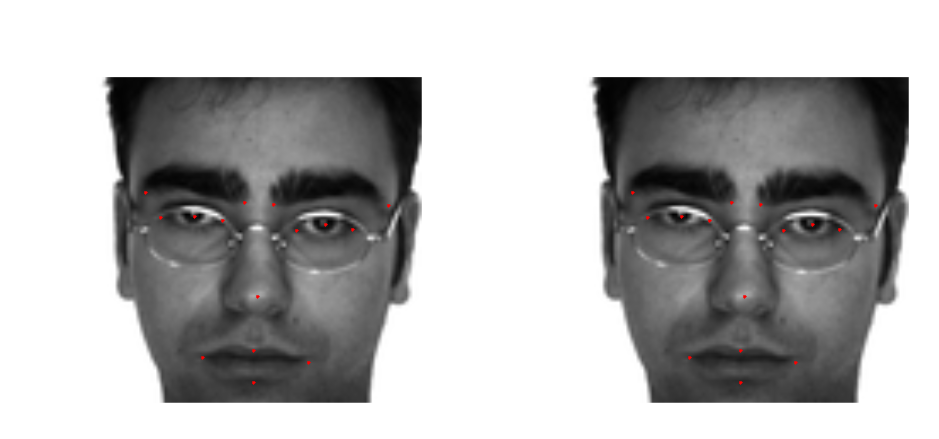

In [3]:
##### define a helper plotting function #####
def plot2(image1, p1, image2, p2):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(image1,(96,96)), cmap = cm.gray)
    for x, y in np.reshape(p1,(len(p1)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(image2,(96,96)), cmap = cm.gray)
    for x, y in np.reshape(p2,(len(p2)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')

##### histogram stretching #####
def HistogramStretching(image):
#     a, b = min(image), max(image) 
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 1
    const = 1.0*(b*l - a*u)/(b - a)
    k = 1.0*(u-l)/(b-a)
    return [k*p+const for p in image]

# plot an example
plot2(ex_x, ex_y*48+48, HistogramStretching(ex_x), ex_y*48+48)

start_time = time.time()
X = [HistogramStretching(x) for x in X]
X_t = [HistogramStretching(x) for x in X_t]
print 'Histogram stretching completed in %.2f seconds' %(time.time()-start_time)

###Feature engineering 2: Gaussian Blur
 - Value of a particular pixel is transformed as the weighted combination of the original value and the values around it.
 - The weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.
 - *Gaussian weight ref:* http://www.pixelstech.net/article/1353768112-Gaussian-Blur-Algorithm

Gaussian blur completed in 930 seconds!


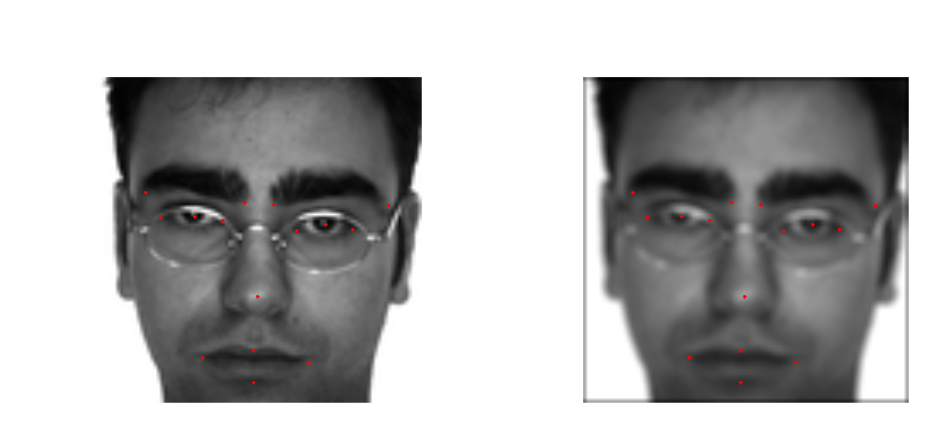

In [4]:
# define the Gaussian weights of neighbors as constant variable
sigma2 = 1.75**2
neighborIndex = [[i,j] for i in range(-1,2) for j in range(-1,2)]
gaussianWeight = np.array([np.exp(-(i**2+j**2)/(2*sigma2))/(2*np.pi*sigma2) for i,j in neighborIndex])
gaussianWeight = gaussianWeight / sum(gaussianWeight)

# function to return the index of neighborhood pixels for pixel at n
def getNeighborAndWeight(n, ncolumn, nrow):    
    # get row and column id first for index i
    (r, c) = divmod(n, ncolumn)
    # get indices for the neighbors (including self)
    neighbors = [[r+i,c+j] for i,j in neighborIndex]
    # get neighbor index and the associated Gauusian weigth
    neighborWeights = []
    for nb, gw in zip(neighbors, gaussianWeight):  # range(len(neighbors)):
        r,c = nb
        if r>=0 and r<nrow and c>=0 and c<ncolumn:                  
            neighborWeights.append([r*ncolumn + c, gw])
    return neighborWeights

# apply Gaussian blur to one image
def gaussianBlurOneSample(x):
    y = np.empty(len(x))
    for i in range(len(x)):
        neighbors = getNeighborAndWeight(i,96,96)
        y[i] = sum([x[j[0]]*j[1] for j in neighbors])
    return y

# plot an example
plot2(ex_x, ex_y*48+48, gaussianBlurOneSample(ex_x), ex_y*48+48)

# blur both training and predicting data
start_time = time.time()
X = [gaussianBlurOneSample(x) for x in X]
X_t = [gaussianBlurOneSample(x) for x in X_t]
print 'Gaussian blur completed in %.f seconds!' %(time.time()-start_time)

###Feature engineering 3: Flip image to increase training sample
 - flip the face horizontally
 - rename x features by switching left and right
 - similar to eyes, brand new to computer --> increase sample with no cost

After merge X:(14098, 9216), y:(14098, 30)


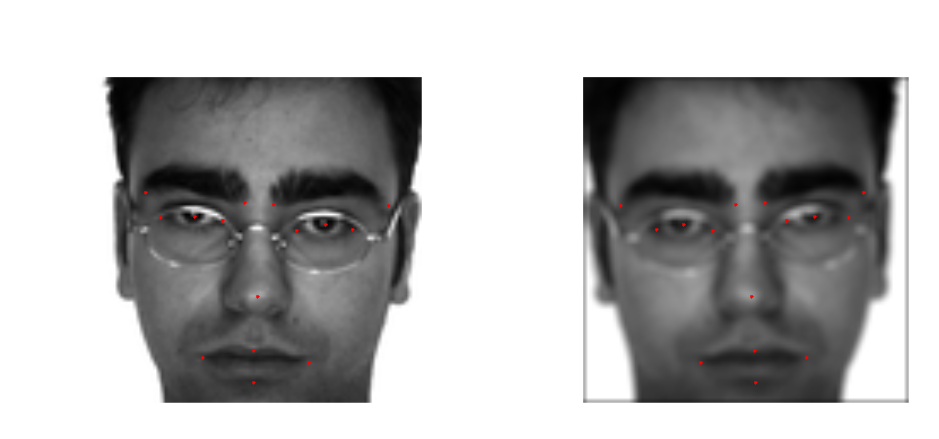

In [5]:
# flip the image
X_flip = np.reshape(np.reshape(X, (-1,1,96,96))[:, :, :, ::-1], (-1, 96*96))

# flip the x coordinate value
multiplier = [-1,1]*(y.shape[1]/2)
y_flip = np.multiply([multiplier,]*y.shape[0], y)

# flip the x coordinates/column name
y_name_flip = []
for name in y_name:
    if 'left' in name.lower():
        y_name_flip.append(name.replace('left','right'))
    elif 'right' in name.lower():
        y_name_flip.append(name.replace('right','left'))
    else:
        y_name_flip.append(name)
y_name_flip=np.array(y_name_flip)
isort = [np.where(y_name_flip==x)[0][0] for x in y_name]

# combine data and align with original column
y = np.concatenate((y, y_flip[:, isort]), axis=0)
X = np.concatenate((X, X_flip), axis=0)
print 'After merge X:%s, y:%s' %(X.shape, y.shape)

plot2(ex_x, ex_y*48+48, X_flip[666], y_flip[666, isort]*48+48)

###Feature engineering 4: Group image to obtain training sets
 - group images with same training keypoints
 

In [6]:
FKP_Count = {}
for x,f in zip(X,y):    
    picker = ~np.isnan(f)
    id = str.join(',', y_name[picker])
    if id not in FKP_Count:
        FKP_Count[id] = 0        
    FKP_Count[id] += 1
    
top_feature = np.array(FKP_Count.keys())[np.argsort(FKP_Count.values())[::-1]]

def getTopGroup(fea):
    isort = [np.where(y_name==x)[0][0] for x in fea]
    picker = np.alltrue(~np.isnan(y[:, isort]), axis=1)   
    return fea, np.reshape(X[picker], (-1, 1, 96, 96)), np.array(y[picker])[:, isort]

feature1, X1, y1 = getTopGroup(top_feature[0].split(','))
feature2, X2, y2 = getTopGroup(top_feature[1].split(','))
x_t = np.reshape(X_t, (-1, 1, 96, 96))

print '1st training set: X1:%s - y1:%s, y1.min:%.3f, y1.max:%.3f' %(str(X1.shape), str(y1.shape), y1.min(), y1.max())
print '2nd training set: X2:%s - y2:%s, y2.min:%.3f, y2.max:%.3f' %(str(X2.shape), str(y2.shape), y2.min(), y2.max())
print 'testing set: x_t:%s' %str(x_t.shape)

1st training set: X1:(14000, 1, 96, 96) - y1:(14000, 8), y1.min:-0.986, y1.max:0.996
2nd training set: X2:(4280, 1, 96, 96) - y2:(4280, 30), y2.min:-0.964, y2.max:0.996
testing set: x_t:(1783, 1, 96, 96)


###Model 1: Convolutional Neural Network by Lasagne
 - 3 Convolutional layers with reception filter: (3x3), (2x2), (2x2) respectively
 - number of layers: 32, 64, 128
 - https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/conv.py
 - 3 downsampling layers with filter size (2x2) for each
 - https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/pool.py
 - choose rectify activation function for each convolutional layer
 - https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/base.py

In [13]:
def getCNN(n_output):
    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('hidden5', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, 96, 96),
        # 3 convoluational layer
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
        # 2 fully connected hidden layer
        hidden4_num_units=500, hidden5_num_units=500,
        # fully connected output layer, no activation function to give continuous output
        output_num_units=n_output, output_nonlinearity=None,

        update_learning_rate=0.02,
        update_momentum=0.80,
           
        regression=True,
        max_epochs=35,
        verbose=1,
        )
    return net

print 'LeNet defined!'

LeNet defined!


###Model 2: 2-Layer Convolutional Neural Network by Theano
  - Because the convergence process is not smooth, we save prediction whenever the cost is reduced during an epoch

In [ ]:
class FacialDetector():
    # Initialize an instance of the class.
    def __init__(self, n_output):
        self._getParameters(n_output)
        self._getModel()

    def _getParameters(self, numClasses):
        numHiddenNodes = 600
        patchWidth = 3
        patchHeight = 3
        featureMapsLayer1 = 32
        # Convolution layers.
        w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
        # Fully connected NN.
        w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1 * 49 * 49, numHiddenNodes))*.01)))
        w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
        self.params = [w_1, w_4, w_5]
        self.srng = RandomStreams()

    def _getModel(self):
        theano.config.floatX = 'float64'
        X = T.tensor4() # conv2d works with tensor4 type
        Y = T.matrix()
        
        w_1, w_4, w_5 = self.params[0], self.params[1], self.params[2]
        y_hat_train = self._model(X, w_1, w_4, w_5, 0.2, 0.5)
        y_hat_predict = self._model(X, w_1, w_4, w_5, 0., 0.)

        self.cost = T.sum(T.sqr(Y - y_hat_train)) #T.sqrt(T.mean(T.sqr(Y - y_hat_train)))
        update = self._backprop(self.cost, self.params)
        self.train = theano.function(inputs=[X, Y], outputs=self.cost, updates=update, allow_input_downcast=True)
        self.predict = theano.function(inputs=[X], outputs=y_hat_predict, allow_input_downcast=True)

    def _model(self, X, w_1, w_4, w_5, p_1, p_2):
        l1 = self._dropout(T.flatten(max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2)), outdim=2), p_1)
        l4 = self._dropout(T.maximum(T.dot(l1, w_4), 0.), p_2)
        return T.dot(l4, w_5)

    def _dropout(self, X, p=0.):
        if p > 0:
            X *= self.srng.binomial(X.shape, p=1 - p)
            X /= 1 - p
        return X

    def _backprop(self, Cost, w, alpha=0.0001, rho=0.66, epsilon=1e-6):
        grads = T.grad(cost=Cost, wrt=w)
        updates = []
        for w1, grad in zip(w, grads):
            # adding gradient scaling
            acc = theano.shared(w1.get_value() * 0.0)
            acc_new = rho * acc + (1 - rho) * grad ** 2
            gradient_scaling = T.sqrt(acc_new + epsilon)
            grad = grad / gradient_scaling
            updates.append((acc, acc_new))
            updates.append((w1, w1 - grad * alpha))
        return updates

    def _shuffleData(self, p, X, y):
        # shuffle it
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        # divide 
        n_train = np.round(X.shape[0]*p)
        return X[:n_train], y[:n_train], X[n_train:], y[n_train:] 

    def fit_predict(self, X, y, x_t, epochs=1000, miniBatchSize=100):
        filename = 'save_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.txt'
        print '\nepoch#: %d, batch#: %d, training#: %s, file: %s\n' %(epochs, miniBatchSize, y.shape, filename)        
        start_time = time.time()
        min_test_rmse = 3.5
        # divide data
        train_data, train_labels, test_data, test_labels = self._shuffleData(0.9, X, y)
        for i in range(epochs):
            epoch_start = time.time()
            # shuffle training data only
            shuffle = np.random.permutation(np.arange(train_data.shape[0]))
            train_data, train_labels = train_data[shuffle], train_labels[shuffle]
            # run mini-batch gradient descent
            for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
                self.cost = self.train(train_data[start:end], train_labels[start:end])
            epoch_time = time.time() - epoch_start
            # rescale labels
            orig_test_labels = test_labels * 48 + 48
            predicted_labels = self.predict(test_data) * 48 + 48
            # predictions are considered accurate if the are off by less than two pixels
            accuracy = np.mean(abs(orig_test_labels - predicted_labels) < 2)
            test_rmse = np.sqrt(np.mean(np.square(predicted_labels - orig_test_labels)))
            new_prediction = 'no'
            # if we have a new low test_rmse, save the weights and predictions
            isSaved = ''
            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                new_prediction = 'yes'
                #save new weights - too big
#                 pickle.dump(self.params, open('kaggle_weights.pkl', 'w'))
                # save new predictions                
                kaggle_predictions = self.predict(x_t) * 48 + 48
                np.savetxt(filename, kaggle_predictions)
                isSaved = '(saved)'
            # print epoch results to screen             
            print '%d) trainRMSE = %.4f, accuracy = %.4f, valRMSE = %.4f, trainTime = %.2f min, endTime = %s %s' %(i+1, self.cost, accuracy, test_rmse, epoch_time/60, time.strftime("%I:%M:%S"), isSaved)
            if test_rmse < 1.0:
                print 'RMSE less than 1, good enough!'
                break
        print '\nTotal train time = %.2f hours' %((time.time() - start_time)/3600)
        return kaggle_predictions

print 'Model refreshed @ %s' %(time.strftime("%I:%M:%S"))

###Training, predicting and results
 - train one model (net1) with X1 dataset - 9510 images with 4 key points
 - train one model (net2) with X2 dataset - 4280 images with all 15 key points
 - each model predicts for 1783 testing images, and gives predictions for their training key ponits
 - for common points we take the weighted mean between two predictions and generate final prediction
 

In [17]:
################### Option 1. Lasagne 5-layer Model ###################

##### CNN for X1 training set () ##### #0.00518 
net1 = getCNN(y1.shape[1])
net1.fit(X1.astype('float32'), y1.astype('float32'))
start_time = time.time()
y_hat1 = net1.predict(x_t)*48+48
print 'Prediction time: %.2f sec, y_hat1.%s' %(time.time()-start_time, str(y_hat1.shape))
filename='./Data/mp1_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.pkl'
pickle.dump([y_hat1], open(filename, 'w'))
# release some memory by remove net1
del net1

##### CNN for X2 training set () ##### #0.00421
net2 = getCNN(y2.shape[1])
net2.fit(X2.astype('float32'), y2.astype('float32'))
start_time = time.time()
y_hat2 = net2.predict(x_t)*48+48 # rescale it back
print 'Prediction time: %.2f sec, y_hat2.%s' %(time.time()-start_time, str(y_hat2.shape))
filename='./Data/mp2_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.pkl'
pickle.dump([y_hat2], open(filename, 'w'))

################### Option 2. Theao 3-layer Model ###################

net2 = FacialDetector(n_output=y2.shape[1])
y2hat = net2.fit_predict(x_t=x_t, X=X2, y=y2, epochs=100, miniBatchSize=10)
del net2 #release some memory

net1 = FacialDetector(n_output=y1.shape[1])
y1hat = net1.fit_predict(x_t=x_t, X=X1, y=y1, epochs=100, miniBatchSize=10)

################### assebmle results to get submission file ###################
def getSubmission(LookupTable):
    # create a dictionary for feature name indexing
    index2 = {feature2[x]:x for x in range(len(feature2))}
    index1 = {feature1[x]:x for x in range(len(feature1))}
    lookupRow = []
    with open(LookupTable) as csvfile:
        # read the lookup file
        lookupReader = csv.reader(csvfile, delimiter=',')
        lookupRow.append(lookupReader.next())
        for row in lookupReader:
            # get the prediction based on image ID and feature name, and attach to the row
            image_id, fea = int(row[1])-1, row[2]
            location = y_hat2[image_id, index2[fea]]
            if fea in index1:
                location = (location + y_hat1[image_id, index1[fea]])/2
            lookupRow.append(np.append(row, location))
    lookupRow = np.array(lookupRow)
    # save row ID and location ID columns only to the submission file
    saveFile = 'submission_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.csv'
    with open(saveFile, 'wb') as f:
        writer = csv.writer(f)
        writer.writerows(lookupRow[:,[0,3]])
    print 'Submission file saved as: %s' %saveFile

getSubmission('./Data/FKD_IdLookupTable.csv')


Submission file saved as: submission_20150806005853.csv


###Error Analysis
 1. Rank prediction error on keypoints and images
  - actual [num_test, num_coordinates] - actual keypoint coordinates from testing faces
  - prediction [num_test, num_coordinates] - predicted keypoint cooridnates for testing faces
  - note: two inputs must have same dimension, and the function is not comparing the absent key points (0) on the face
 2. Visualization

In [8]:
##### print a rank for predidction RMSE #####
def RankPredictionRMSE(actual, prediction):
    print '\nError Analysis:'
    feaRMSE, keyRMSE = [], []
    # for each feature
    for i in range(len(feature_name)):               
        picker = actual[:,i]>0
        feaRMSE.append(np.sqrt(np.mean((actual[picker,i]-prediction[picker,i])**2)))
    feaRMSE = np.array(feaRMSE)
    feaRank = np.argsort(feaRMSE)
    
    # for each keypoint
    keypoints = [x[:-2] for x in feature_name]
    indexes = np.unique(keypoints, return_index=True)[1]
    keypoints = np.array([keypoints[i] for i in sorted(indexes)])
    for i in range(len(keypoints)):
        act = actual[:,i*2:(i+1)*2]
        pre = prediction[:,i*2:(i+1)*2]
        picker = act[:,0]>0
        keyRMSE.append(np.sqrt(np.mean((act[picker]-pre[picker])**2)))
    keyRMSE = np.array(keyRMSE)
    keyRank = np.argsort(keyRMSE)
    showKey = np.append(keypoints[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    showRMSE = np.append(keyRMSE[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    
    # for each testing image    
    imgRMSE = np.array([np.sqrt(np.mean((pre[act>0]-act[act>0])**2)) for pre, act in zip(prediction, actual)])
    imgRank = np.argsort(imgRMSE)
    
    # print the RMSE ranking results    
    template = "{0:35}{1:20}{2:35}{3:10}"
    print template.format("feature name", "RMSE", "keypoint", "RMSE") # header
    for f, r1, k, r2 in zip(feature_name[feaRank][::-1], feaRMSE[feaRank][::-1], showKey, showRMSE):
        print template.format(f, *['%.3f' %r1, '%s' %(k if k!='0.0' else ''), '%s' %('%.3f' %r2 if r2!=0 else '')])
    
    # plot top 10 badly predicted testing faces   
    n_top = np.min([10, actual.shape[0]])
    print '\nTop %d faces with highest RMSE:' %n_top
    plt.figure(figsize=(20, 10))
    i=1
    for iid in imgRank[::-1][:n_top]:
        plt.subplot(2,5,i)        
        plt.imshow(np.reshape(dev_faces[iid], (96,96)), cmap = cm.gray)
        picker = actual[iid]>0
        pre = np.reshape(prediction[iid, picker],(sum(picker)/2,2))
        kp = np.reshape(actual[iid, picker], (sum(picker)/2,2))
        for a,p in zip(kp, pre):
            plt.plot(a[0],a[1],'r.')
            plt.plot(p[0],p[1],'c.')
        plt.axis('off')
        plt.title('[%d] RMSE: %.3f' %(iid,imgRMSE[iid]))
        i+=1

##### Visualization #####
def plot(image, points=[], pred=[]):
    # print a picture to see
    plt.figure(figsize=(8, 8))
    if len(image)==96:
        plt.imshow(image, cmap = cm.gray)
    else:
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray)
    plt.axis('off')
    if len(points)>0:
        for i in range(len(points)/2):
            plt.plot(points[2*i], points[2*i+1],'r.')
    if len(pred)>0:
        for i in range(len(pred)/2):
            plt.plot(pred[2*i],pred[2*i+1],'c.')


###Appendix I: Mean Patch Searching Classifier

In [ ]:
class MeanPatchSearching:
    # Initialize an instance of the class.
    def __init__(self, patch_size=10, search_size=10, stretch=True):
        self.patch_size = patch_size
        self.search_size = search_size
        self.isStretch = stretch
        self.patch_index = np.array([[i,j] for i in range(-patch_size, patch_size+1) 
                                           for j in range(-patch_size, patch_size+1)])
        self.search_index = np.array([[i,j] for i in range(-search_size, search_size+1) 
                                            for j in range(-search_size, search_size+1)])
    
    # train the model
    def fit(self, train_faces, train_coordinates):
        start = datetime.now()
        # stretch input if needed
        if False: #self.isStretch:
            train_faces = np.array([self._histogramStretching(x) for x in train_faces])
        # number of faces to train
        self.num_examples = train_faces.shape[0]
        print 'number of training faces: %d' %self.num_examples
        # assuming coordinates are (x,y) pairs for each key point
        self.num_keypoints = train_coordinates.shape[1]/2
        # image dimension
        self.ncolumn = np.sqrt(train_faces.shape[1])
        self.nrow = self.ncolumn
        
        # get patches and their centers for all keypoints
        self.patches, self.patch_centers = [], []
        for i in range(self.num_keypoints):
            # get coordinates of current keypoint
            coordinates = train_coordinates[:,i*2:(i+1)*2]
            # filter zero values (empty from file)
            picker = coordinates[:,0]>0                        
            # get patch if at least one face has this point
            if sum(picker)>0:
                # get patch for this key point
                self.patches.append(self._getPatch(train_faces[picker], coordinates[picker]))
                # get center for this keypoint
                self.patch_centers.append(np.mean(coordinates[picker], axis=0))
        
        # convert to numpy array      
        self.patches = np.array(self.patches)
        self.patch_centers = np.array(self.patch_centers)
        self.num_keypoints = self.patches.shape[0]
        self.training_time = (datetime.now()-start).total_seconds()/60.0
        print 'training patches shape: %s' %str(self.patches.shape)
        print 'training time: %.1f minutes' %self.training_time
        # show training patches
#         self._plotPatches()
        
    # Make prediction for each test face and return coordinates.
    def predict(self, test_faces):
        start = datetime.now()
        # stretch input if needed
        if self.isStretch:
            test_faces = np.array([self._histogramStretching(x) for x in test_faces])
        self.num_predict = test_faces.shape[0]
        print 'number of predicting faces: %d' %self.num_predict
        predictions = []
        for i in range(self.num_predict):
            if np.mod((i+1), self.num_predict/10)==0:
                print 'Complete %d%% ...' %(100.0*(i+1)/self.num_predict)
            pred = self._predictOneFace(test_faces[i])            
            predictions.append(np.reshape(pred, (1,2*self.num_keypoints))[0])        
        self.pred_coor = np.array(predictions)
        self.predict_time = (datetime.now()-start).total_seconds()/60.0
        print 'Done! - Predict time: %.1f minutes' %self.predict_time
        return self.pred_coor
    
    # calculate total Root Mean Squared Error (RMSE)
    def RMSE(self, actual, pred=[]):
        if len(pred)==0:
            pred = self.pred_coor
        picker = actual>0        
        tRMSE = np.sqrt(np.sum((actual[picker]-pred[picker])**2)/np.sum(picker)) 
        return 'Total RMSE: %.2f, patch size: %d, search size: %d' %(tRMSE, self.patch_size, self.search_size)
    
    # save the submission file based on prediction made for test images
    def getSubmission(self, LookupTable, feature_name):
        # create a dictionary for feature name indexing
        feature_index = {x:np.where(feature_name==x)[0][0] for x in feature_name}
        lookupRow = []
        with open(LookupTable) as csvfile:
            # read the lookup file
            lookupReader = csv.reader(csvfile, delimiter=',')
            lookupRow.append(lookupReader.next())
            for row in lookupReader:
                # get the prediction based on image ID and feature name, and attach to the row
                location = self.pred_coor[int(row[1])-1, feature_index[row[2]]]
                lookupRow.append(np.append(row, location))
        lookupRow = np.array(lookupRow)
        # save row ID and location ID columns only to the submission file
        saveFile = 'submission_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.csv'
        with open(saveFile, 'wb') as f:
            writer = csv.writer(f)
            writer.writerows(lookupRow[:,[0,3]])
        print 'Submission file saved as: %s' %saveFile
        return lookupRow
        
    # get the prediction for one face
    def _predictOneFace(self, face):
        # get prediction for each keypoint available in the model
        pred_coor = []
        for gold_p, center in zip(self.patches, self.patch_centers):
            # get the candidate points based on search size
            candidates = self._getCandidates(center)
            # get a patch for each candidate point     
            pred_p = [self._getPatch([face], [x]) for x in candidates]

            # compare the patches from candidate points with gold_p
            # TODO: use better distance
            dist = [np.sum(np.abs(gold_p-x)) for x in pred_p]
            pred_coor.append(candidates[np.argmin(dist)])
        return pred_coor
    
    # get the candidate points - return the coordinates
    def _getCandidates(self, center):  
        r, c = np.round(center)
        candidates = np.array([[r+i, c+j] for i,j in self.search_index])
        # only keep those within the bound
        picker = (np.sum(candidates>=0,axis=1) + np.sum(candidates<[self.nrow,self.ncolumn],axis=1))==4        
        return candidates[picker]
    
    # get the patch for one keypoint from all faces
    def _getPatch(self, faces, keypoints):    
        patches = []
        for face, keypoint in zip(faces, keypoints):
            # get keypoint pixel row and column index
            r, c = np.round(keypoint)        
            # get indices for the patch (including self)
            neighbors = np.array([[r+i, c+j] for i,j in self.patch_index])
            if np.sum(neighbors>=0)+np.sum(neighbors<[self.nrow,self.ncolumn]) == np.prod(neighbors.shape)*2:
                patches.append(face[[r*self.ncolumn + c for r,c in neighbors]])
#             else:
#                 print 'warning - nonconforming patch'
#         print np.array(patches).shape
        return np.mean(patches, axis=0)

    # histogram stretching pre-processing
    def _histogramStretching(self, image):
        # a, b = min(image), max(image) 
        a, b = np.percentile(image, 5), np.percentile(image, 95)
        l, u = 0, 255
        const = 1.0*(b*l - a*u)/(b - a)
        k = 1.0*(u-l)/(b-a)
        return [k*p+const for p in image]
    
    # plot average patch from training
    def _plotPatches(self):
        n_side = 2*self.patch_size+1
        keypoints = np.reshape([x[:-2] for x in feature_name],(self.num_keypoints,2))
        plt.figure(figsize=(16, 8))
        i = 1
        for point, patch in zip(keypoints[:,0], self.patches):
            plt.subplot(3,5,i)
            plt.imshow(np.reshape(patch,(n_side,n_side)), cmap = cm.gray)
            plt.title(point)
            plt.axis('off')
            i += 1
        plt.show()
        

##### Get baseline score #####
# training
mps = MeanPatchSearching(patch_size=9, search_size=5, stretch=True)
mps.fit(train_faces[:150], train_coordinates[:150])
# predicting
predictions = mps.predict(test_faces)
mps.getSubmission('./Data/FKD_IdLookupTable.csv', feature_name)

###Appendix II: 5-layer CNN using Theano

In [4]:
## (1) Parameters
numHiddenNodes = 600 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

# For convonets, we will work in 2d rather than 1d.  The facial images are 96x96 in 2d.
imageWidth = 96
# n_train = np.round(X1.shape[0]*0.9)
# train_X, train_y =  X1[:n_train], y1[:n_train]
# test_X, test_y = X1[-n_train:], y1[-n_train:] 

n_train = np.round(X2.shape[0]*0.9)
train_X, train_y =  X2[:n_train], y2[:n_train]
test_X, test_y = X2[n_train:], y2[n_train:] 

# Convolution layers.  
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth-1, patchHeight-1))*.01)))
w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth-1, patchHeight-1))*.01)))
# Fully connected NN. - 12x12 - dimension of L3 (11) plus bias (1)
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 12 * 12, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, train_y.shape[1]))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]

## (2) Model
theano.config.floatX = 'float64'
X = T.tensor4() # conv2d works with tensor4 type
Y = T.matrix()

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X

# Theano provides built-in support for add convolutional layers
def model(X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
    l1 = dropout(max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'), 0.), (2, 2)), p_1)
    l2 = dropout(max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2)), p_1)
    # flatten to switch back to 1d layers - with "outdim = 2" (2d) output 
    l3 = dropout(T.flatten(max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2)), outdim=2), p_1) 
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_2)
    return T.dot(l4, w_5) #T.nnet.softmax(T.dot(l4, w_5))

y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)

## (3) Cost
cost = T.sqrt(T.mean(T.sqr(Y - y_hat_train))) # T.mean(T.nnet.categorical_crossentropy(y_hat_train, Y))

## (4) Minimization.  
def backprop(cost, w, alpha=0.01, rho=0.8, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_hat_predict, allow_input_downcast=True)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    print 'Training started @%s, buckle up!' %datetime.now()
    print 'Training set: %s, dev set: %s' %(train_y.shape, test_y.shape)
    
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost = train(train_X[start:end], train_y[start:end])
#             print 'cost: %.3f' %cost
        print '%d) %s: RMSE = %.4f' %(i+1, datetime.now(), np.sqrt(np.mean(np.square(test_y - predict(test_X)))))
    print 'Total training time = %.2f' %(time.time() - start_time)

# gradientDescentStochastic(10)

# start_time = time.time()
# predict(test_data)   
# print 'predict time = %.2f' %(time.time() - start_time)